<a href="https://colab.research.google.com/github/xxxnmxhj00/Mini-Project/blob/main/%5BTF%5Dkor_bert_nsmc_model_from_transformers_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers
!pip install --upgrade tf_keras

In [ ]:
!pip install Korpora

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS']= '1'

In [ ]:
!pip show tensorflow transformers tf_keras

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
---
Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-pa

In [ ]:

import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf

In [ ]:
from Korpora import Korpora
Korpora.fetch(
    corpus_name='nsmc',
    root_dir='./data',
    force_download=True,
)

[nsmc] download ratings_train.txt: 14.6MB [00:00, 79.8MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 43.5MB/s]                            


In [ ]:
train_data = pd.read_table('/content/data/nsmc/ratings_train.txt')
test_data = pd.read_table('/content/data/nsmc/ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [ ]:
test_data[:5] # 상위 5개 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()
# train_data 데이터프레임의 document 열에서 **고유한 값(중복되지 않은 값)**의 개수를 계산


(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

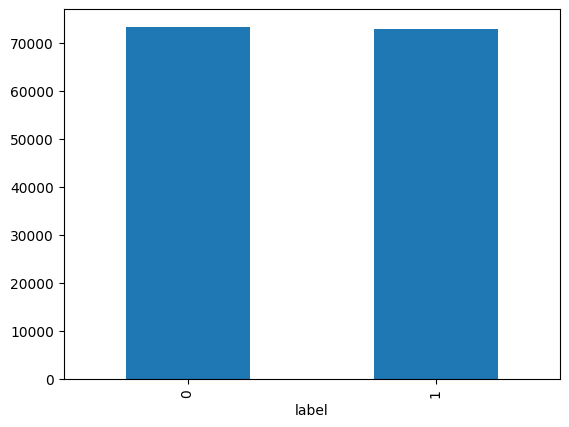

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') # 널값이 존재하는 행 제거
print(train_data.isnull().values.any()) # 널값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

146182


토크나이저를 이용한 정수 인코딩

이미 학습해놓은 모델을 사용한다면

In [ ]:
import transformers

In [ ]:
transformers.__version__

'4.44.2'

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
test_data = test_data.dropna(how = 'any')

In [ ]:
print(len(test_data))

49997


In [ ]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

In [ ]:
X_train = tokenizer(X_train_list, truncation=True,padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [ ]:
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


데이터셋 생성 및 모델 학습

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
num_class= 2

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=num_class, from_pt=True)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110618882 (421.98 MB)
Trainable params: 110618882 (421.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callback_earlystop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=2)



model.fit(
      train_dataset.shuffle(10000).batch(32), epochs=1, batch_size=64,
      validation_data=val_dataset.shuffle(10000).batch(32),
      callbacks=[callback_earlystop])

4569/4569 [==============================] - 4376s 949ms/step - loss: 0.2827 - accuracy: 0.8803 - val_loss: 0.2582 - val_accuracy: 0.8958


In [ ]:
model.evaluate(val_dataset.batch(1024))

49/49 [==============================] - 417s 9s/step - loss: 0.2582 - accuracy: 0.8958


[0.25816190242767334, 0.8958137631416321]

모델 저장

In [ ]:
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

('nsmc_model/bert-base/tokenizer_config.json',
 'nsmc_model/bert-base/special_tokens_map.json',
 'nsmc_model/bert-base/vocab.txt',
 'nsmc_model/bert-base/added_tokens.json',
 'nsmc_model/bert-base/tokenizer.json')

모델 로드 및 테스트

In [ ]:
from transformers import TextClassificationPipeline

loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at nsmc_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nsmc_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Hardware accelerator e.g. GPU is available in the environment, but no

In [ ]:
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]

[{'label': 'LABEL_0', 'score': 0.5381532907485962},
 {'label': 'LABEL_1', 'score': 0.4618466794490814}]

In [ ]:
text_classifier('노잼')[0]

[{'label': 'LABEL_0', 'score': 0.9962050318717957},
 {'label': 'LABEL_1', 'score': 0.0037949385587126017}]

In [ ]:
text_classifier('재미있어요')[0]

[{'label': 'LABEL_0', 'score': 0.10129424184560776},
 {'label': 'LABEL_1', 'score': 0.898705780506134}]

In [ ]:
text_classifier('와 너무 재밌어서 눈물나고 미쳐버릴거 같았어요ㅋㅋ 이런걸 돈 주고보네')[0]

[{'label': 'LABEL_0', 'score': 0.2676648795604706},
 {'label': 'LABEL_1', 'score': 0.732335090637207}]

In [ ]:
text_classifier('이런걸 재밌다고 하는 애들은 평소의 삶이 얼마나 재미 없다는거임?')[0]

[{'label': 'LABEL_0', 'score': 0.902548611164093},
 {'label': 'LABEL_1', 'score': 0.09745139628648758}]

In [ ]:
text_classifier('시발 개재밌어')[0]

[{'label': 'LABEL_0', 'score': 0.14647667109966278},
 {'label': 'LABEL_1', 'score': 0.853523313999176}]